
# Intro


**Notes**

The main bulk of the material comes from https://developers.google.com/machine-learning/recommendation/overview/candidate-generation. If you want to go further later, you can take a look at http://nicolas-hug.com/blog/matrix_facto_3. It is absolutely not expected to look at these two links for the interviews  or to complete the test.

**Context**: 

We want to build a movies' recommender in order to get new movies to watch during the lock down. We will base our work on a variation of the MovieLens dataset. 
The data consists of movies seen by the users, some informations about the movies, and some informations about the users. The problem consists in predicting which movies a given user might like.

We are presenting you here first a naive approach in order to familarize yourself with the problem and show you how it might be solved.

**Task**:

The code presented is a first implementation but has a number of shortcomings in its structure and features (more on that in the conclusion). Your task consist in producing a refactoring, so as to be one step closer to a "clean" code.

**Evaluation**:

Our goal here is two fold:
- See how you understand a problem and adapt to an already given approach to tackle it.
- See how you can design new features.
- See how you manipulate python code: understanding, ideas to refactor etc ...

The projects will be evaluated on the quality of the source code produced.

# The data

## First, let's load some data.

In [460]:
import pandas as pd

users = pd.read_csv("data/users.csv")
print(users.shape)
users.head()

(6040, 5)


,user_id,gender,age,occupation,zip_code
0,0,F,1,10,48067
1,1,M,56,16,70072
2,2,M,25,15,55117
3,3,M,45,7,02460
4,4,M,25,20,55455


In [461]:
movies = pd.read_csv("data/movies.csv")
print(movies.shape)
movies.head()

(3883, 21)


,movie_id,title,year,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,...,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,0,Toy Story,1995,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Jumanji,1995,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Grumpier Old Men,1995,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Waiting to Exhale,1995,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Father of the Bride Part II,1995,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [462]:
ratings = pd.read_csv("data/ratings.csv")
print(ratings.shape) # Over 1M ratings
ratings.head()

(1000209, 3)


,user_id,movie_id,rating
0,0,1192,5
1,0,660,3
2,0,913,3
3,0,3407,4
4,0,2354,5


## EDA :

Before anything else, I think it is important and relevant to do some exploratory data analysis to know what we are working with and to maybe detect some anomalies in the dataset (presence of *NaN* values, negative ratings, no movie genre assigned, etc...)


### Number of occurences for each movie genre :

Text(0, 0.5, 'Occurences of each genres')

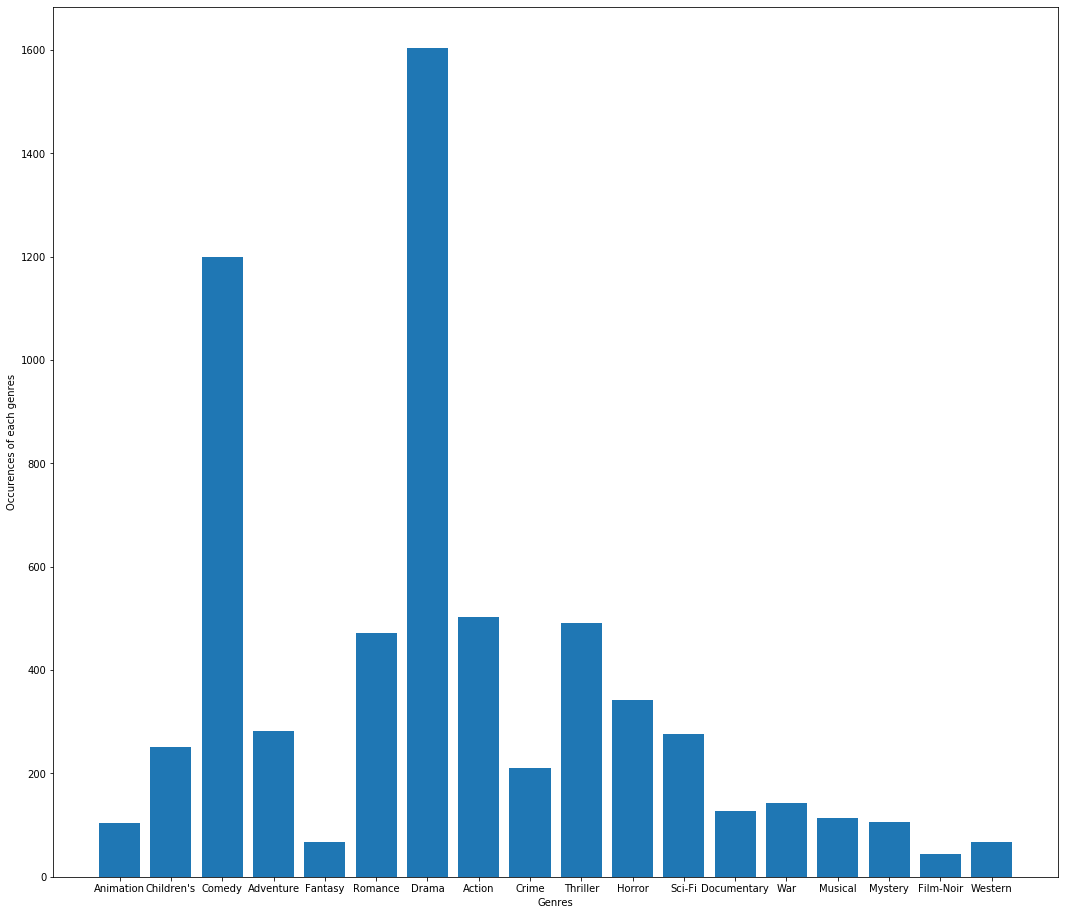

In [463]:
import matplotlib.pyplot as plt
import numpy as np

genre_cols = ["Animation", "Children's", 
       'Comedy', 'Adventure', 'Fantasy', 'Romance', 'Drama',
       'Action', 'Crime', 'Thriller', 'Horror', 'Sci-Fi', 'Documentary', 'War',
       'Musical', 'Mystery', 'Film-Noir', 'Western']

occurences_of_each_genre = movies[genre_cols].sum()

plt.figure(figsize=(18,16))
plt.bar(np.arange(len(occurences_of_each_genre)),occurences_of_each_genre.to_list())
plt.xticks(np.arange(len(occurences_of_each_genre)),genre_cols)
plt.xlabel('Genres')
plt.ylabel('Occurences of each genres')

This bar chart allows us to see the distribution of each movie genre present in the dataset. 
Drama and Comedy are obviously the two most prominent genres in this study.

### Count of occurences for the different number of genres for movies

Text(0.5, 0, 'Number of genres for a movie')

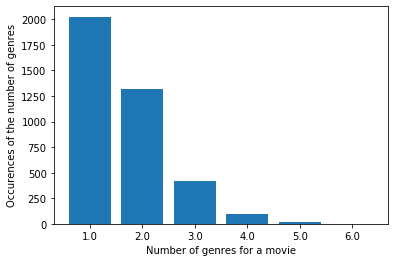

In [464]:
nb_gender_per_movies = movies[genre_cols]
nb_gender_per_movies.loc[:,'count']=movies[genre_cols].sum(axis=1)

nb_gender_set=list(set(nb_gender_per_movies['count']))

counts_nb_gender = list()
for i in nb_gender_set:
    counts_nb_gender.append(nb_gender_per_movies.loc[nb_gender_per_movies['count']==i].shape[0])
    
plt.bar(nb_gender_set,counts_nb_gender)
plt.xticks(nb_gender_set,nb_gender_set)
plt.ylabel('Occurences of the number of genres')
plt.xlabel('Number of genres for a movie')

We can see two relevant informations on this bar chart :

1. No movie has 0 genre assigned, which is good to know for the rest of the study.

2. Most movies are concentrated in the first two bars, which means that a large majority of them is assigned to one or two genres. This will also reveal to be relevant in what's comming next.

We might now want to explore in details the most common movie genre to see how they compose with other genres.

### Drama and comedy genres study

Text(0.5, 0, 'Number of genres for a comedy movie')

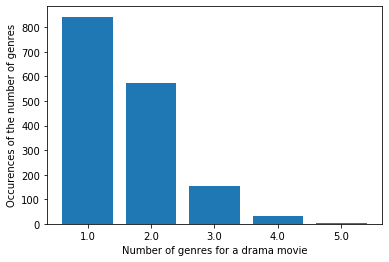

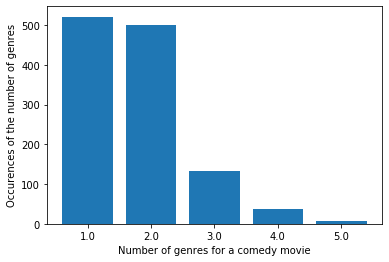

In [465]:
nb_gender_per_drama_movies = movies[genre_cols].loc[nb_gender_per_movies['Drama']==1]
nb_gender_per_drama_movies.loc[:,'count']=movies[genre_cols].loc[nb_gender_per_movies['Drama']==1].sum(axis=1)

nb_gender_per_comedy_movies = movies[genre_cols].loc[nb_gender_per_movies['Comedy']==1]
nb_gender_per_comedy_movies.loc[:,'count']=movies[genre_cols].loc[nb_gender_per_movies['Comedy']==1].sum(axis=1)

nb_gender_drama_set=list(set(nb_gender_per_drama_movies['count']))
nb_gender_comedy_set=list(set(nb_gender_per_comedy_movies['count']))

counts_nb_gender_drama = list()
counts_nb_gender_comedy = list()

for i in nb_gender_drama_set:
    counts_nb_gender_drama.append(nb_gender_per_drama_movies.loc[nb_gender_per_drama_movies['count']==i].shape[0])
    
for i in nb_gender_comedy_set:
    counts_nb_gender_comedy.append(nb_gender_per_comedy_movies.loc[nb_gender_per_comedy_movies['count']==i].shape[0])
    
plt.bar(nb_gender_drama_set,counts_nb_gender_drama)
plt.xticks(nb_gender_drama_set,nb_gender_drama_set)
plt.ylabel('Occurences of the number of genres')
plt.xlabel('Number of genres for a drama movie')

plt.figure(2)
plt.bar(nb_gender_comedy_set,counts_nb_gender_comedy)
plt.xticks(nb_gender_comedy_set,nb_gender_comedy_set)
plt.ylabel('Occurences of the number of genres')
plt.xlabel('Number of genres for a comedy movie')

This informs us that drama and comedy genres follows the general trend of movies: most of them have 1 or 2 genres assigned.
    
### Ratings distribution

Text(0, 0.5, 'Occurences of each rating')

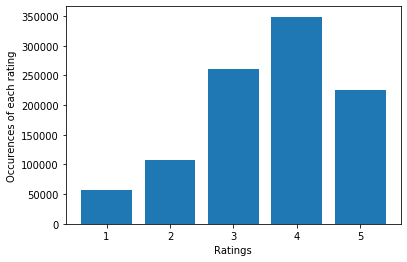

In [466]:
ratings_counts = []
ratings_set = list(set(ratings['rating']))

for i in ratings_set:
    ratings_counts.append(ratings.loc[ratings['rating']==i].shape[0])
    
plt.bar(ratings_set,ratings_counts)
plt.xticks(ratings_set,ratings_set)
plt.xlabel('Ratings')
plt.ylabel('Occurences of each rating')

This chart teaches us two important things :

1. The ratings are discrete and entirely in the {1,2,3,4,5} set (no 0, negative, or NaN rating).
2. Most ratings are concentrated between 3 and 5.

### Dataframe merging for correlation heatmap studies (find relevant features)

Here, we are going to merge the data with the foreign keys included in the dataset (`movie_id` and `user_id`) :


In [467]:
import seaborn as sns


columns = genre_cols+['movie_id','user_id','occupation','zip_code','year','gender','age','rating']
df = movies.merge(ratings,left_on='movie_id',right_on='movie_id').merge(users,left_on='user_id',right_on='user_id')[columns]

df = pd.concat([df,pd.get_dummies(df['gender'],prefix='gender')],axis=1).drop(['gender'],axis=1) # one-hot encode the gender feature
df = pd.concat([df,pd.get_dummies(df['occupation'],prefix='occupation')],axis=1).drop(['occupation'],axis=1) # one-hot encode the occupation feature
corr_pearson = df.corr().loc['rating'].apply(abs)

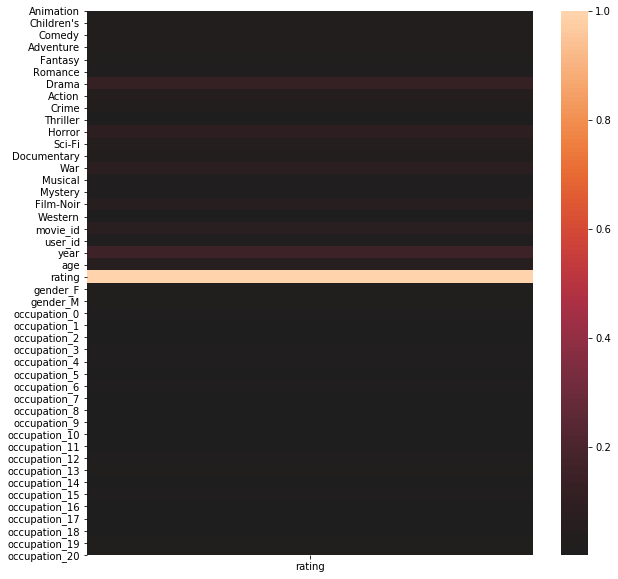

In [468]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(pd.DataFrame(corr_pearson),center=0)

From this heatmap of correlation, we can conclude one main thing : the profile of a user (age, occupation, gender) does not seem to have an effect on their rating. 

Therefore, if we want to include a feature where a user get recommendations based on other similar users, it would have to be more about their tastes in movies rather than their profile. 

### EDA Conclusion

From this exploratory data analysis we learned a few relevant information. 

First, and a very important one, is that all the data is in the expected shape. Every movie has atleast one genre assigned, every rating is between 1 and 5. This will allow us to work on the data without the fear of having to deal with unconform data.

Second, we now know that most movies have 1 or 2 genres assigned, and that is also true for `Drama` and `Comedy` genres which are the most popular. Also, the ratings are mostly comprised of *3,4 and 5* ratings.

Third, in the case of implementation of a recommendation based on similar users, it would not be relevant to use the profile (gender, occupation or age), but rather go for tastes in common.

# Content-based Filtering

Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback. We dont use other users information !

For example, if user `A` liked `Harry Potter 1`, he/she will like `Harry Potter 2`

In [469]:
%%html
<img src='https://miro.medium.com/max/1642/1*BME1JjIlBEAI9BV5pOO5Mg.png' height="300" width="250"/>

What are similar movies ? In order to answer to this question we need to build a similiarity measure. 

## Features

This measure will operate on the characteristics (**features**) of the movies to determine which are close. In our case, we have access to the genres of the movies. For example, the genres of `Toy Story` are: `Animation`, `Children's` and `Comedy`. This is represented as follow in our dataset:

In [470]:
genre_and_title_cols = ['title'] + genre_cols 

movies[genre_and_title_cols].head()

,title,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,Toy Story,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Jumanji,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Grumpier Old Men,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Waiting to Exhale,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Father of the Bride Part II,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Similarity

Now that we have some features, we will try to find a function that performs a similiarity measure. The Similarity function will take two items (two list of features) and return a number proportional to their similarity. 

For the following we will consider that the Similarity between two movies is the number of genres they have in common.

Here is an example with `Toy Story` and `E.T`

In [471]:
toy_story_genres = movies[genre_and_title_cols].loc[movies.title == 'Toy Story'][genre_cols].iloc[0]
toy_story_genres

Animation      1.0
Children's     1.0
Comedy         1.0
Adventure      0.0
Fantasy        0.0
Romance        0.0
Drama          0.0
Action         0.0
Crime          0.0
Thriller       0.0
Horror         0.0
Sci-Fi         0.0
Documentary    0.0
War            0.0
Musical        0.0
Mystery        0.0
Film-Noir      0.0
Western        0.0
Name: 0, dtype: float64

In [472]:
et_genres = movies[genre_and_title_cols].loc[movies.title == 'E.T. the Extra-Terrestrial'][genre_cols].iloc[0]
et_genres

Animation      0.0
Children's     1.0
Comedy         0.0
Adventure      0.0
Fantasy        1.0
Romance        0.0
Drama          1.0
Action         0.0
Crime          0.0
Thriller       0.0
Horror         0.0
Sci-Fi         1.0
Documentary    0.0
War            0.0
Musical        0.0
Mystery        0.0
Film-Noir      0.0
Western        0.0
Name: 1081, dtype: float64

In [473]:
et_genres.values * toy_story_genres

Animation      0.0
Children's     1.0
Comedy         0.0
Adventure      0.0
Fantasy        0.0
Romance        0.0
Drama          0.0
Action         0.0
Crime          0.0
Thriller       0.0
Horror         0.0
Sci-Fi         0.0
Documentary    0.0
War            0.0
Musical        0.0
Mystery        0.0
Film-Noir      0.0
Western        0.0
Name: 0, dtype: float64

In [474]:
(et_genres.values * toy_story_genres).sum()/(toy_story_genres.values.sum()) # scalar product divided by the number of genres of Toy Story

0.3333333333333333

So our similarity measure returns `0.3333333333333333` for these two movies - because one out of three of the genres of Toy Story is shared with E.T (`Children`).

Let's see another example where we compare `Toy Stories` and `Pocahontas`

In [475]:
pocahontas_genres = movies[genre_and_title_cols].loc[movies.title == 'Pocahontas'][genre_cols].iloc[0]
pocahontas_genres

Animation      1.0
Children's     1.0
Comedy         0.0
Adventure      0.0
Fantasy        0.0
Romance        1.0
Drama          0.0
Action         0.0
Crime          0.0
Thriller       0.0
Horror         0.0
Sci-Fi         0.0
Documentary    0.0
War            0.0
Musical        1.0
Mystery        0.0
Film-Noir      0.0
Western        0.0
Name: 47, dtype: float64

In [476]:
(pocahontas_genres.values * toy_story_genres).sum()/(toy_story_genres.values.sum())

0.6666666666666666

This tells us that `Pocahontas` is closer to `Toy Stories` than `E.T.` which makes sense - two out of the three genres of Toy Story is found in Pocahontas (`Animation` and `Children`).

I took the decision of normalizing the similarity between 0 and 1, because this way we have shared boundaries of similarity for every movie.
Top similarity is 1, bottom similarity is 0.

## Scaling up

Ok, that's a nice measure. Now we are going to scale it up to all movies of our dataset. To do so smartly, let's take a look at the operation we just did, but from a mathematical point of view. To do so, we will think of the list of features of a movie as a vector `V`. Then, our similarity measure between `Toy Story` and `E.T.` becomes:
$ V_{ToyStory} \cdot V_{ET}^{T}$

More generally the similarity measure between a movie `i` and another movie `j` is : $ V_{i} \cdot V_{j}^{T}$

Now we can think of `movies` as a matrix containing all features vectors describing the movies. Here is how our similiarity measure looks in this context:

![](imgs/dot_product_matrices.png)

To obtain the similiarity between all movies of our dataset we have to perform the dot product of the `movies` matrix with the transposed of the `movies` matrix.
The `lambda` function allows to divide each row by the sum of the row. This way, the resulting similarity matrix is normalized between 0 and 1.

In [477]:
similarity = pd.DataFrame(data=movies[genre_cols].apply(lambda x : x/sum(x),axis=1).values.dot(movies[genre_cols].values.T),index=movies.loc[:,'movie_id'],columns=movies.loc[:,'movie_id'])
similarity #has to be read through lines : similarity.loc[0,2]!=similarity.loc[2,0]
#it means that movie_id=0 has one of his three genres shared with movie_id=2
#and movie_id=2 has one of his two genres shared with movie_id=0

movie_id,0,1,2,3,4,5,6,7,8,9,...,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951
movie_id,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.333333,0.333333,0.333333,0.333333,0.0,0.333333,0.333333,0.0,0.000000,...,0.333333,0.333333,0.666667,0.0,0.0,0.333333,0.0,0.0,0.0,0.0
1,0.333333,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.666667,0.0,0.333333,...,0.000000,0.000000,0.666667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.500000,0.000000,1.000000,0.500000,0.500000,0.0,1.000000,0.000000,0.0,0.000000,...,0.500000,0.500000,0.000000,0.0,0.0,0.500000,0.0,0.0,0.0,0.0
3,0.500000,0.000000,0.500000,1.000000,0.500000,0.0,0.500000,0.000000,0.0,0.000000,...,0.500000,1.000000,0.000000,0.5,0.0,0.500000,0.5,0.5,0.5,0.5
4,1.000000,0.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,0.0,0.000000,...,1.000000,1.000000,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,1.000000,0.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,0.0,0.000000,...,1.000000,1.000000,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
3948,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,0.000000,1.0,0.0,0.000000,1.0,1.0,1.0,1.0
3949,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,0.000000,1.0,0.0,0.000000,1.0,1.0,1.0,1.0


We can now get the similarity between `Toy Story` and any other movie of our dataset

In [478]:
similarity_with_toy_story = similarity.loc[0,:] # 0 is Toy Story
similarity_with_toy_story

movie_id
0       1.000000
1       0.333333
2       0.333333
3       0.333333
4       0.333333
          ...   
3947    0.333333
3948    0.000000
3949    0.000000
3950    0.000000
3951    0.000000
Name: 0, Length: 3883, dtype: float64

In [479]:
for i in range(10):
    print(f"Similarity between Toy story and {movies.iloc[i]['title']} (index {i}) is {similarity_with_toy_story[i]}")

Similarity between Toy story and Toy Story (index 0) is 1.0
Similarity between Toy story and Jumanji (index 1) is 0.3333333333333333
Similarity between Toy story and Grumpier Old Men (index 2) is 0.3333333333333333
Similarity between Toy story and Waiting to Exhale (index 3) is 0.3333333333333333
Similarity between Toy story and Father of the Bride Part II (index 4) is 0.3333333333333333
Similarity between Toy story and Heat (index 5) is 0.0
Similarity between Toy story and Sabrina (index 6) is 0.3333333333333333
Similarity between Toy story and Tom and Huck (index 7) is 0.3333333333333333
Similarity between Toy story and Sudden Death (index 8) is 0.0
Similarity between Toy story and GoldenEye (index 9) is 0.0


## A bit of polishing

### Helpers:

We also built some helpers to handle the movies dataset:

In [480]:
from content_based_filtering.helpers.movies import get_movie_id, get_movie_name, get_movie_year
    
print (get_movie_id(movies, 'Toy Story'))
print (get_movie_id(movies, 'Die Hard'))

print (get_movie_name(movies, 0))
print (get_movie_name(movies, 1000))
print (get_movie_year(movies, 1000))

0
1023
Toy Story
Parent Trap, The
1961


### Finding similar movies:
Here is a method giving us the movie the most similar to another movie:

In [481]:
def get_most_similar(similarity, movie_name, year=None, top=similarity.shape[0]): 
    #I changed the default top to the similarity's number of rows. To get the similarity with all other movies.
    index_movie = get_movie_id(movies, movie_name, year)
    best = list(similarity.loc[index_movie,:].sort_values(ascending=False).index)
    return [(ind, movies[movies['movie_id']==ind].title.values[0], similarity.loc[index_movie, ind]) for ind in best[:top] if ind != index_movie]

In [482]:
get_most_similar(similarity,'Toy Story')[:10]

[(672, 'Space Jam', 1.0),
 (3753, 'Adventures of Rocky and Bullwinkle, The', 1.0),
 (3750, 'Chicken Run', 1.0),
 (2077, 'Jungle Book, The', 1.0),
 (2079, 'Lady and the Tramp', 1.0),
 (2080, 'Little Mermaid, The', 1.0),
 (2101, 'Steamboat Willie', 1.0),
 (2140, 'American Tail, An', 1.0),
 (2141, 'American Tail: Fievel Goes West, An', 1.0),
 (3610, 'Saludos Amigos', 1.0)]

In [483]:
get_most_similar(similarity, 'Psycho', 1960)[:10]

[(0, 'Toy Story', 1.0),
 (866, 'Carpool', 1.0),
 (904, 'It Happened One Night', 1.0),
 (900, 'Funny Face', 1.0),
 (2656, 'Rocky Horror Picture Show, The', 1.0),
 (2658, 'It Came from Hollywood', 1.0),
 (897, 'Philadelphia Story, The', 1.0),
 (891, 'Twelfth Night', 1.0),
 (2670, 'Notting Hill', 1.0),
 (2674, 'Twice Upon a Yesterday', 1.0)]

### Giving a recommendation:

And finally, let's find some movies to recommend based on previously liked movies:

In [491]:
def get_recommendations(user_id,nb_top_movies=3,nb_movies_return=5):
    
    train=ratings[ratings['user_id']==user_id].sample(frac=0.7).reset_index(drop=True)
    test=pd.concat([ratings[ratings['user_id']==user_id],train]).drop_duplicates(keep=False)
    #Introducing a train and test split to evaluate the recommendation system (70%-30%)
    
    top_movies = train[train['user_id'] == user_id].sort_values(by='rating', ascending=False).head(nb_top_movies)['movie_id']
    index=['movie_id', 'title', 'similarity']

    most_similars = []
    for top_movie in top_movies:
        most_similars += get_most_similar(similarity, get_movie_name(movies, top_movie), get_movie_year(movies, top_movie))

    res = pd.DataFrame(most_similars, columns=index).groupby('movie_id',as_index=False).max().sort_values(by='similarity', ascending=False) 
    # I changed the drop_duplicates to a groupby to remove the duplicates, but keeping the maximum between the duplicates
    
    for index,row in test.iterrows():
       print(f"Movie id: {row['movie_id']}, Rated: {row['rating']}, Computed Similarity: {res[res['movie_id']==row['movie_id']]['similarity'].values}")
        
    return res.head(nb_movies_return)

get_recommendations(user_id=0,nb_top_movies=10)


Movie id: 1192, Rated: 5, Computed Similarity: [1.]
Movie id: 660, Rated: 3, Computed Similarity: [1.]
Movie id: 2803, Rated: 5, Computed Similarity: [1.]
Movie id: 594, Rated: 5, Computed Similarity: [1.]
Movie id: 2917, Rated: 4, Computed Similarity: [0.33333333]
Movie id: 2790, Rated: 4, Computed Similarity: [0.33333333]
Movie id: 2686, Rated: 3, Computed Similarity: [0.66666667]
Movie id: 2017, Rated: 4, Computed Similarity: [0.66666667]
Movie id: 3104, Rated: 5, Computed Similarity: [1.]
Movie id: 47, Rated: 5, Computed Similarity: [1.]
Movie id: 1096, Rated: 4, Computed Similarity: [1.]
Movie id: 744, Rated: 3, Computed Similarity: [0.66666667]
Movie id: 3185, Rated: 4, Computed Similarity: [1.]
Movie id: 2761, Rated: 4, Computed Similarity: [0.]
Movie id: 2691, Rated: 4, Computed Similarity: [0.33333333]
Movie id: 1245, Rated: 4, Computed Similarity: [1.]


,movie_id,title,similarity
0,0,Toy Story,1.0
2027,2095,Sleeping Beauty,1.0
2010,2078,Kidnapped,1.0
2011,2079,Lady and the Tramp,1.0
2012,2080,"Little Mermaid, The",1.0


In [495]:
get_recommendations(user_id=150,nb_top_movies=10)

Movie id: 1174, Rated: 5, Computed Similarity: [1.]
Movie id: 3860, Rated: 4, Computed Similarity: [0.33333333]
Movie id: 1319, Rated: 4, Computed Similarity: [1.]
Movie id: 3862, Rated: 3, Computed Similarity: [1.]
Movie id: 2124, Rated: 2, Computed Similarity: [1.]
Movie id: 3792, Rated: 4, Computed Similarity: [1.]
Movie id: 1256, Rated: 4, Computed Similarity: [0.33333333]
Movie id: 2996, Rated: 5, Computed Similarity: [0.33333333]
Movie id: 652, Rated: 2, Computed Similarity: [0.5]
Movie id: 586, Rated: 4, Computed Similarity: [1.]
Movie id: 3004, Rated: 2, Computed Similarity: [0.33333333]
Movie id: 5, Rated: 4, Computed Similarity: [0.66666667]
Movie id: 6, Rated: 2, Computed Similarity: [1.]
Movie id: 1192, Rated: 4, Computed Similarity: [1.]
Movie id: 732, Rated: 5, Computed Similarity: [0.66666667]
Movie id: 1196, Rated: 5, Computed Similarity: [1.]
Movie id: 735, Rated: 3, Computed Similarity: [1.]
Movie id: 1198, Rated: 5, Computed Similarity: [1.]
Movie id: 592, Rated: 4, 

,movie_id,title,similarity
1941,2009,Metropolis,1.0
2193,2261,About Last Night...,1.0
2176,2244,Working Girl,1.0
2179,2247,Say Anything...,1.0
2181,2249,Men Don't Leave,1.0


With the testing system implemented, we can see that sometimes the recommendation system can function well (Similarity = 1 for a rating of 5), but can also sometimes fail (Similarity of 0.333 for a rating of 5 | but a similarity of 1 for a rating of 1)


# Conclusion:

The code presented is a first implementation but has a number of shortcomings preventing the collaboration of multiple MLE and Data Scientists:
- It is not possible to introduce easily new features mainly because the code is just a bunch of functions in one file.
- The code can not be scaled to other datasets or variations of the tasks.
- There is no evaluation of the performances.
- There is no testing

Additionaly a number we could think of some features to add, for example, what about looking at similar users to find a recommendation for our targeted user ?